In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import h5py
from panns_inference import AudioTagging, SoundEventDetection, labels

sys.path.append('../ASC_AED_JoinTask/models/')
sys.path.append('../ASC_AED_JoinTask/Datasets/')
import ASC_datasets
import models
import torch

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Loading ASC Model
cnn9_model = models.Cnn_9layers_AvgPooling(10, 'logsoftmax')
device = torch.device('cuda:1')
cnn9_model.load_state_dict(torch.load('../audioData/TUTUrban2018/baseline2019/checkpoints/main/logmel_64frames_64melbins/TUT-urban-acoustic-scenes-2018-development/holdout_fold=1/Cnn_9layers_AvgPooling/5000_iterations.pth', map_location=device)['model'])

<All keys matched successfully>

In [3]:
# Loading the scalers
f = h5py.File('../audioData/TUTUrban2018/baseline2019/scalars/logmel_64frames_64melbins/TUT-urban-acoustic-scenes-2018-development.h5', 'r')
mean = f['mean']
std = f['std']

In [4]:
# Loading Dataset
TUT_AUD_DIR = ASC_datasets.TUT_AUD_DIR
TUT_DF = pd.read_csv('../ASC_AED_JoinTask/csv_files/baseline_preds_5000.csv')
labels = ['airport', 'shopping_mall', 'metro_station', 'street_pedestrian', 
    'public_square', 'street_traffic', 'tram', 'bus', 'metro', 'park']

In [5]:
SAMPLE_RATE = 32000
WINDOW_SIZE = 1024
HOP_SIZE = 500
MEL_BINS = 64
FMIN = 50
FMAX = 14000
N_FFT = 1024

fps = SAMPLE_RATE // HOP_SIZE
aud_dur = 10
frames_num = fps * aud_dur

class LogMelExtractor(object):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, fmax):
        '''Log mel feature extractor. 
        
        Args:
          sample_rate: int
          window_size: int
          hop_size: int
          mel_bins: int
          fmin: int, minimum frequency of mel filter banks
          fmax: int, maximum frequency of mel filter banks
        '''
        
        self.window_size = window_size
        self.hop_size = hop_size
        self.window_func = np.hanning(window_size)
        
        self.melW = librosa.filters.mel(
            sr=sample_rate, 
            n_fft=window_size, 
            n_mels=mel_bins, 
            fmin=fmin, 
            fmax=fmax).T
        '''(n_fft // 2 + 1, mel_bins)'''

    def transform(self, audio):
        '''Extract feature of a singlechannel audio file. 
        
        Args:
          audio: (samples,)
          
        Returns:
          feature: (frames_num, freq_bins)
        '''
    
        window_size = self.window_size
        hop_size = self.hop_size
        window_func = self.window_func
        
        # Compute short-time Fourier transform
        stft_matrix = librosa.core.stft(
            y=audio, 
            n_fft=window_size, 
            hop_length=hop_size, 
            window=window_func, 
            center=True, 
            dtype=np.complex64, 
            pad_mode='reflect').T
        '''(N, n_fft // 2 + 1)'''
    
        # Mel spectrogram
        mel_spectrogram = np.dot(np.abs(stft_matrix) ** 2, self.melW)
        
        # Log mel spectrogram
        logmel_spectrogram = librosa.core.power_to_db(
            mel_spectrogram, ref=1.0, amin=1e-10, 
            top_db=None)
        
        logmel_spectrogram = logmel_spectrogram.astype(np.float32)
        
        return logmel_spectrogram

logmel_obj = LogMelExtractor(SAMPLE_RATE, WINDOW_SIZE, HOP_SIZE, MEL_BINS, FMIN, FMAX)

In [6]:
def get_features(audio_path):
    audio_, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
    logmel = logmel_obj.transform(audio_)
    scaled = (logmel - mean) / std
    return scaled


def get_preds(audio_path):
    feats = get_features(audio_path)
    cnn9_model.eval()
    with torch.inference_mode():
        output = (cnn9_model(torch.from_numpy(feats[0:640,:]).unsqueeze(0).to(device))).cpu().detach()
    return labels[int(torch.argmax(output))]

In [7]:
fft_freqs = librosa.fft_frequencies(sr=SAMPLE_RATE, n_fft=N_FFT)
mel_freqs = librosa.mel_frequencies(n_mels=MEL_BINS, fmax=FMAX, fmin=FMIN)

# Ablate features according to index, and returns new audio
def ablate_features(index, audio):

    audio_stft = librosa.stft(audio, n_fft=N_FFT)
    low_index = index*4
    high_index = low_index+3
    l0 = fft_freqs>=mel_freqs[low_index]
    l1 = fft_freqs<=mel_freqs[high_index]

    for i in range(len(l0)):
        if l0[i] & l1[i]:
            audio_stft[i,:] = np.complex64(0+0j)

    y_new = librosa.istft(audio_stft, n_fft=N_FFT)
    return y_new

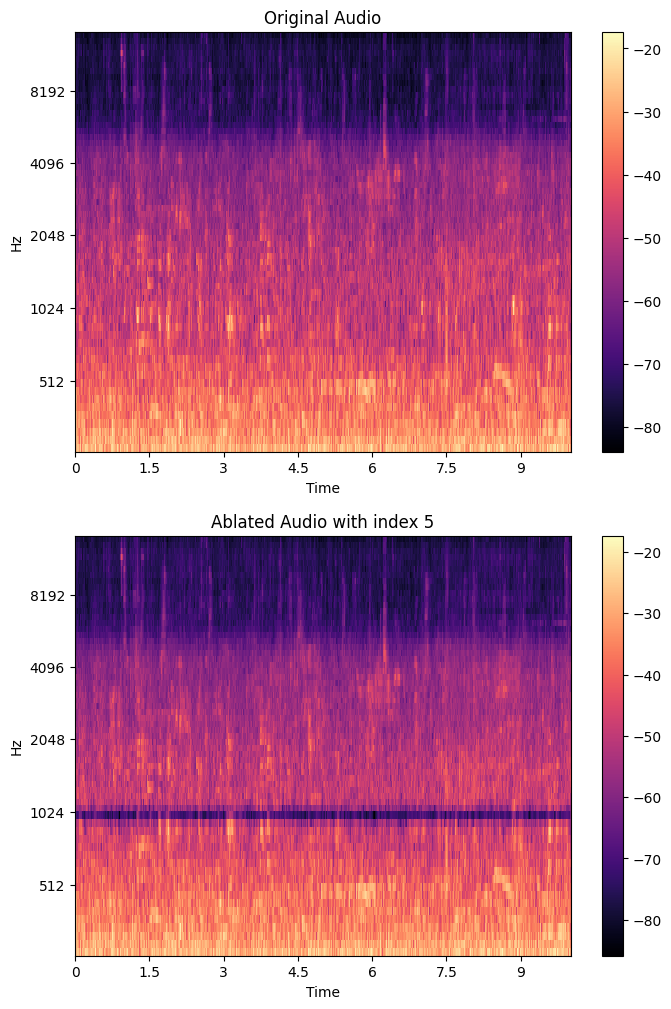

In [8]:
aud, sr = librosa.load(os.path.join(TUT_AUD_DIR, TUT_DF['files'].iloc[0]), sr=SAMPLE_RATE)
logmel = logmel_obj.transform(aud).transpose()
ablated = logmel_obj.transform(ablate_features(4, aud)).transpose()

plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.title('Original Audio')
librosa.display.specshow(logmel, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', win_length=N_FFT, hop_length=HOP_SIZE, fmax=FMAX, fmin=FMIN)
plt.colorbar()
plt.subplot(2,1,2)
plt.title('Ablated Audio with index 5')
librosa.display.specshow(ablated, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', win_length=N_FFT, hop_length=HOP_SIZE, fmax=FMAX, fmin=FMIN)
plt.colorbar()

In [22]:
ablated_scene_preds = []
cnn9_model = cnn9_model.to(device)

# Ablated Features scene preds loop
for i, row in TUT_DF.iterrows():
    org_aud_fname = (os.path.join(TUT_AUD_DIR, row['files']))
    audio, sr = librosa.load(org_aud_fname, sr=SAMPLE_RATE)
    print(i)
    ablated_feat_preds = []
    for j in range(16):
        ablated_aud = ablate_features(j, audio)
        ablated_logmel = (logmel_obj.transform(ablated_aud)[0:640,:] - mean) / std

        cnn9_model.eval()
        with torch.inference_mode():
            output = cnn9_model(torch.from_numpy(ablated_logmel).unsqueeze(0).to(device)).cpu().detach()
        ablated_feat_preds.append(labels[int(torch.argmax(output))])
    ablated_scene_preds.append(ablated_feat_preds)

In [3]:
import pandas as pd

df = pd.read_csv('Cnn9_featAblation.csv')

203